# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Import EarlyStopping class


In [9]:
from models.EarlyStopping import EarlyStopping

Define what happens in each epoch


In [10]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    early_stopper = EarlyStopping(path=f'earlystop_{MODEL}.pt')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best validation accuracy model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

        # Check for early stopping (based on val_loss)
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            break

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [11]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [13]:
from CNNMFCCs import CNNMFCCs

model = CNNMFCCs()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs(
  (conv1): Conv1d(40, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=22016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
)

Visualize the model


In [14]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 172]           1,936
            Conv1d-2              [-1, 32, 172]           1,568
            Conv1d-3              [-1, 64, 172]           6,208
            Conv1d-4             [-1, 128, 172]          24,704
           Dropout-5             [-1, 128, 172]               0
            Linear-6                  [-1, 128]       2,818,176
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                    [-1, 9]             585
Total params: 2,861,433
Trainable params: 2,861,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.49
Params size (MB): 10.92
Estimated Total Size (MB): 11.43
-------------------------------------

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 57.49it/s, Loss=1.3412355184555054, Elapsed=1.6345s, ETA=0.0000s]


Epoch 1 completed in 7.5081s
Train Loss: 1.4314382637856324 - Train Accuracy: 36.39673458311662
Validation Loss: 1.2101302599906922 - Validation Accuracy: 46.538623891937526

Epoch 2/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.28it/s, Loss=1.3197520971298218, Elapsed=1.5700s, ETA=0.0000s]


Epoch 2 completed in 7.3302s
Train Loss: 1.1508016439876116 - Train Accuracy: 47.8053413536555
Validation Loss: 1.1114268398284912 - Validation Accuracy: 49.83115238497256

Epoch 3/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 71.93it/s, Loss=1.3604557514190674, Elapsed=1.3749s, ETA=0.0000s]


Epoch 3 completed in 7.0635s
Train Loss: 1.0524175027546856 - Train Accuracy: 52.19013590827887
Validation Loss: 1.0202140386899312 - Validation Accuracy: 54.70662726888983

Epoch 4/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.85it/s, Loss=1.0826152563095093, Elapsed=1.4807s, ETA=0.0000s]


Epoch 4 completed in 6.7898s
Train Loss: 0.9868477216001191 - Train Accuracy: 54.99197213993352
Validation Loss: 0.9946257917086283 - Validation Accuracy: 54.61165048543689

Epoch 5/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.07it/s, Loss=1.6615021228790283, Elapsed=1.4174s, ETA=0.0000s]


Epoch 5 completed in 6.7624s
Train Loss: 0.9387918004410805 - Train Accuracy: 56.58849867709912
Validation Loss: 0.9812273780504862 - Validation Accuracy: 56.22625580413677

Epoch 6/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.20it/s, Loss=1.519467830657959, Elapsed=1.5628s, ETA=0.0000s] 


Epoch 6 completed in 7.1859s
Train Loss: 0.8957228996505627 - Train Accuracy: 58.540060152416274
Validation Loss: 0.9678130888938904 - Validation Accuracy: 56.373997467285776

Epoch 7/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.94it/s, Loss=1.2673354148864746, Elapsed=1.4335s, ETA=0.0000s]


Epoch 7 completed in 7.0610s
Train Loss: 0.8564064264986556 - Train Accuracy: 60.26548472445218
Validation Loss: 0.9521525231997172 - Validation Accuracy: 58.505698607007176

Epoch 8/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 58.62it/s, Loss=1.330873727798462, Elapsed=1.6331s, ETA=0.0000s] 


Epoch 8 completed in 6.9488s
Train Loss: 0.8110188957239162 - Train Accuracy: 62.002216141652156
Validation Loss: 0.9487288665771484 - Validation Accuracy: 59.3710426340228

Epoch 9/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.26it/s, Loss=1.3838815689086914, Elapsed=1.5086s, ETA=0.0000s]


Epoch 9 completed in 6.7724s
Train Loss: 0.7765701902395039 - Train Accuracy: 63.40426494199588
Validation Loss: 0.9266410366694132 - Validation Accuracy: 59.159983115238504

Epoch 10/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.81it/s, Loss=1.4650901556015015, Elapsed=1.4729s, ETA=0.0000s]


Epoch 10 completed in 6.8446s
Train Loss: 0.7380771350137071 - Train Accuracy: 64.82892743266774
Validation Loss: 0.9669535954793295 - Validation Accuracy: 60.46855213170114

EarlyStopping counter: 1/7
Epoch 11/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.91it/s, Loss=1.5919126272201538, Elapsed=1.4785s, ETA=0.0000s]


Epoch 11 completed in 6.9365s
Train Loss: 0.7020961012626659 - Train Accuracy: 66.5633974808349
Validation Loss: 0.9503274647394816 - Validation Accuracy: 61.26002532714225

EarlyStopping counter: 2/7
Epoch 12/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.11it/s, Loss=1.591832160949707, Elapsed=1.4617s, ETA=0.0000s] 


Epoch 12 completed in 6.7993s
Train Loss: 0.6627329754174789 - Train Accuracy: 67.96092354311301
Validation Loss: 1.0057288956642152 - Validation Accuracy: 61.51329674968341

EarlyStopping counter: 3/7
Epoch 13/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.22it/s, Loss=1.681963324546814, Elapsed=1.5495s, ETA=0.0000s] 


Epoch 13 completed in 7.0964s
Train Loss: 0.6282409956689515 - Train Accuracy: 69.42629067637547
Validation Loss: 1.0071378143628438 - Validation Accuracy: 62.32587589700296

EarlyStopping counter: 4/7
Epoch 14/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 59.35it/s, Loss=1.747676968574524, Elapsed=1.5983s, ETA=0.0000s] 

Epoch 14 completed in 6.8422s
Train Loss: 0.5814570826774388 - Train Accuracy: 70.98211257095045
Validation Loss: 1.085838708082835 - Validation Accuracy: 59.45546644153651

EarlyStopping counter: 5/7
Epoch 15/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.23it/s, Loss=1.55074143409729, Elapsed=1.5776s, ETA=0.0000s]  


Epoch 15 completed in 6.8694s
Train Loss: 0.5562687798731589 - Train Accuracy: 72.47009339454105
Validation Loss: 1.1182156149546305 - Validation Accuracy: 63.52891515407345

EarlyStopping counter: 6/7
Epoch 16/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.35it/s, Loss=1.4000223875045776, Elapsed=1.4878s, ETA=0.0000s]


Epoch 16 completed in 7.0191s
Train Loss: 0.5239202614464512 - Train Accuracy: 73.56007326835666
Validation Loss: 1.1191668971379598 - Validation Accuracy: 62.705783030814686

EarlyStopping counter: 7/7
🔁 Early stopping triggered!


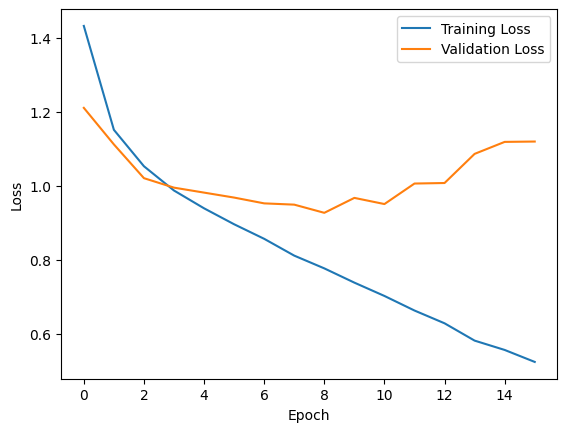

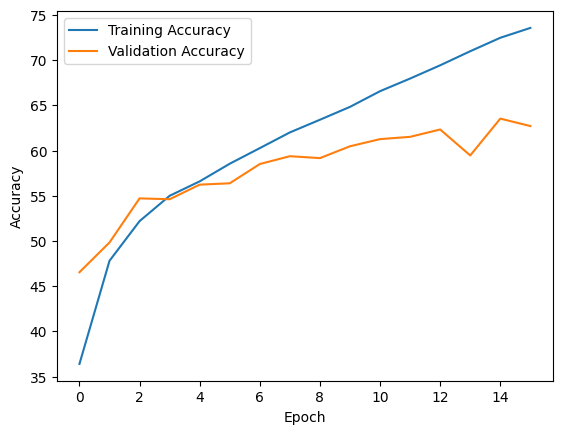

In [16]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [18]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:02<00:00, 35.31it/s]


Test Accuracy: 0.6267
Test Precision: 0.6367
Test Recall: 0.6267
Test F1-score: 0.6232

              precision    recall  f1-score   support

       Anger       0.59      0.76      0.66       916
       Bored       0.64      0.82      0.72      1098
     Disgust       0.37      0.60      0.46       291
        Fear       0.41      0.56      0.47       308
       Happy       0.66      0.51      0.58      1914
     Neutral       0.65      0.49      0.56      2226
    Question       0.71      0.78      0.74      1139
         Sad       0.66      0.63      0.65       857
    Surprise       0.65      0.70      0.67       728

    accuracy                           0.63      9477
   macro avg       0.59      0.65      0.61      9477
weighted avg       0.64      0.63      0.62      9477



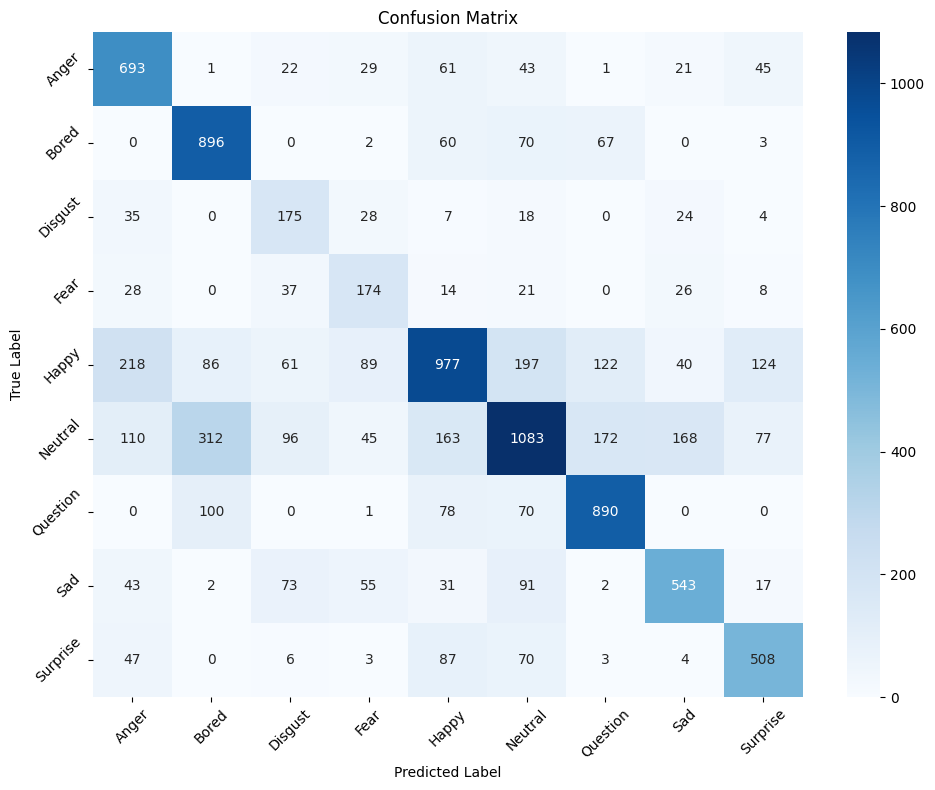

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)